In [1]:
print('starting import')
from dipy.io.image import load_nifti, load_nifti_data
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.io.image import save_nifti
import matplotlib.pyplot as plt
import numpy as np
from dipy.segment.mask import median_otsu
from dipy.core.histeq import histeq
from dipy.reconst.csdeconv import auto_response
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.viz import window, actor, has_fury
import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy, color_fa
from dipy.data import get_sphere
from dipy.viz import window, actor
import dipy.denoise.noise_estimate as ne
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.viz import colormap
print('import done')

starting import
import done


# Read the data

volumes : (110, 110, 68, 167)
voxel size : (2.0, 2.0, 2.0)
b0 volumes : (110, 110, 68, 7)


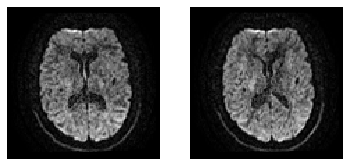

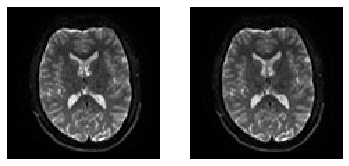

In [2]:
data, affine, img = load_nifti("e1367\s16858\s16858_sansinterOpt_DTI_4B_64_32_HB3_20200706153150_5.nii.gz", return_img=True)
print('volumes :',data.shape)
print('voxel size :',img.header.get_zooms()[:3])

axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 1].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
#plt.savefig('data.png',dpi=500);
plt.show()

bvals, bvecs = read_bvals_bvecs("e1367\s16858\s16858_sansinterOpt_DTI_4B_64_32_HB3_20200706153150_5.bval","e1367\s16858\s16858_sansinterOpt_DTI_4B_64_32_HB3_20200706153150_5.bvec")
gtab = gradient_table(bvals, bvecs)
#print(gtab.bvals)
#print(gtab.bvecs)

S0s = data[:, :, :, gtab.b0s_mask]
print('b0 volumes :',S0s.shape)
axial_middle = S0s.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(S0s[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(S0s[:, :, axial_middle, 5].T, cmap='gray', origin='lower')
#plt.savefig('data.png',dpi=500);
plt.show()


# Brain extraction

(110, 110, 68, 167)
34


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


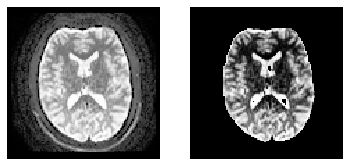

In [8]:
maskdata, mask = median_otsu(data, vol_idx=range(10,50), median_radius=2, numpass=1, autocrop=False)
print(maskdata.shape)

sli = data.shape[2] // 2
print(sli)
plt.figure('Brain segmentation')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(histeq(data[:, :, sli, 0].astype('float')).T,cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(histeq(maskdata[:, :, sli,0].astype('float')).T,cmap='gray', origin='lower');

import scipy
scipy.misc.imsave('original.jpg', histeq(data[:, :, sli, 0].astype('float')).T)
scipy.misc.imsave('brain.jpg', histeq(maskdata[:, :, sli,0].astype('float')).T)

# DTI

In [4]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data,mask=mask)

(110, 110, 68, 3, 3)


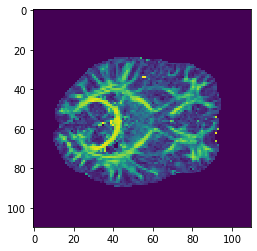

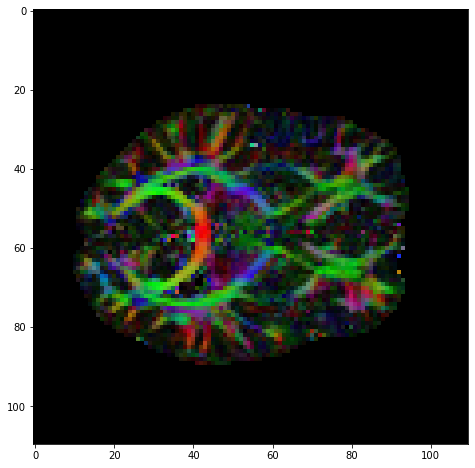

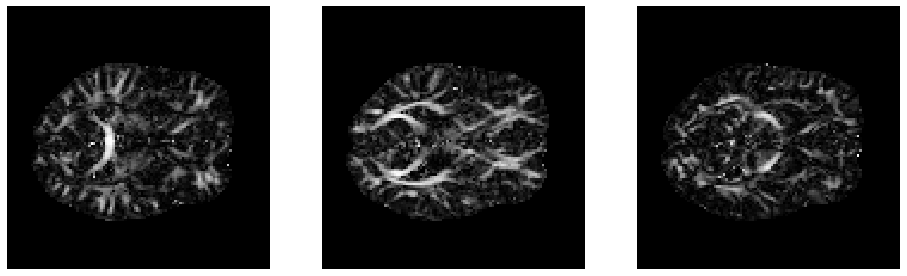

In [5]:
FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)]=0
FA = np.clip(FA,0,1)
RGB = color_fa(FA, tenfit.evecs)
save_nifti('test.nii.gz',np.array(255*RGB,'uint8'), affine)

MD = dti.mean_diffusivity(tenfit.evals)
print(np.shape(tenfit.quadratic_form))

plt.figure()
plt.imshow(FA[:, :, 30]);
plt.figure(figsize=(16,8))
plt.imshow(RGB[:, :, 30,:]);

plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(RGB[:, :, 30,0],cmap='gray');
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(RGB[:, :, 30,1],cmap='gray');
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(RGB[:, :, 30,2],cmap='gray');

In [6]:
sphere = get_sphere('repulsion724')
ren = window.Scene();
evals = tenfit.evals[13:43, 44:74, 28:29]
evecs = tenfit.evecs[13:43, 44:74, 28:29]
cfa = RGB[13:43, 44:74, 28:29]
cfa /= cfa.max()
ren.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,scale=0.3));
window.record(ren, n_frames=1, out_path='tensor_ellipsoids.png',size=(600, 600));
window.show(ren)

#dti_peaks = peaks_from_model(tenmodel, maskdata, default_sphere,relative_peak_threshold=.8,min_separation_angle=45, mask=mask)
#ren = window.Scene()
#ren.add(actor.peak_slicer(dti_peaks.peak_dirs,dti_peaks.peak_values,colors=None))
#window.record(ren, out_path='dti_direction_field.png', size=(900, 900))
#window.show(ren, size=(800, 800))

C:\Users\SIMON MATHIEU\AppData\Roaming\Python\Python37\site-packages\fury\actor.py:1191: RuntimeWarning: invalid value encountered in true_divide
  ea /= ea.max()


# Denoising

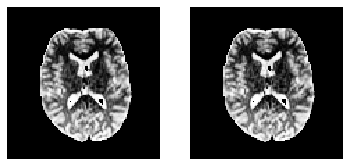

In [8]:
from dipy.denoise.localpca import mppca
import math
import numpy as np
pr = math.ceil((np.shape(maskdata)[3]**(1/3)-1)/2)
denoised = mppca(maskdata, patch_radius=pr)


<Figure size 1152x576 with 0 Axes>

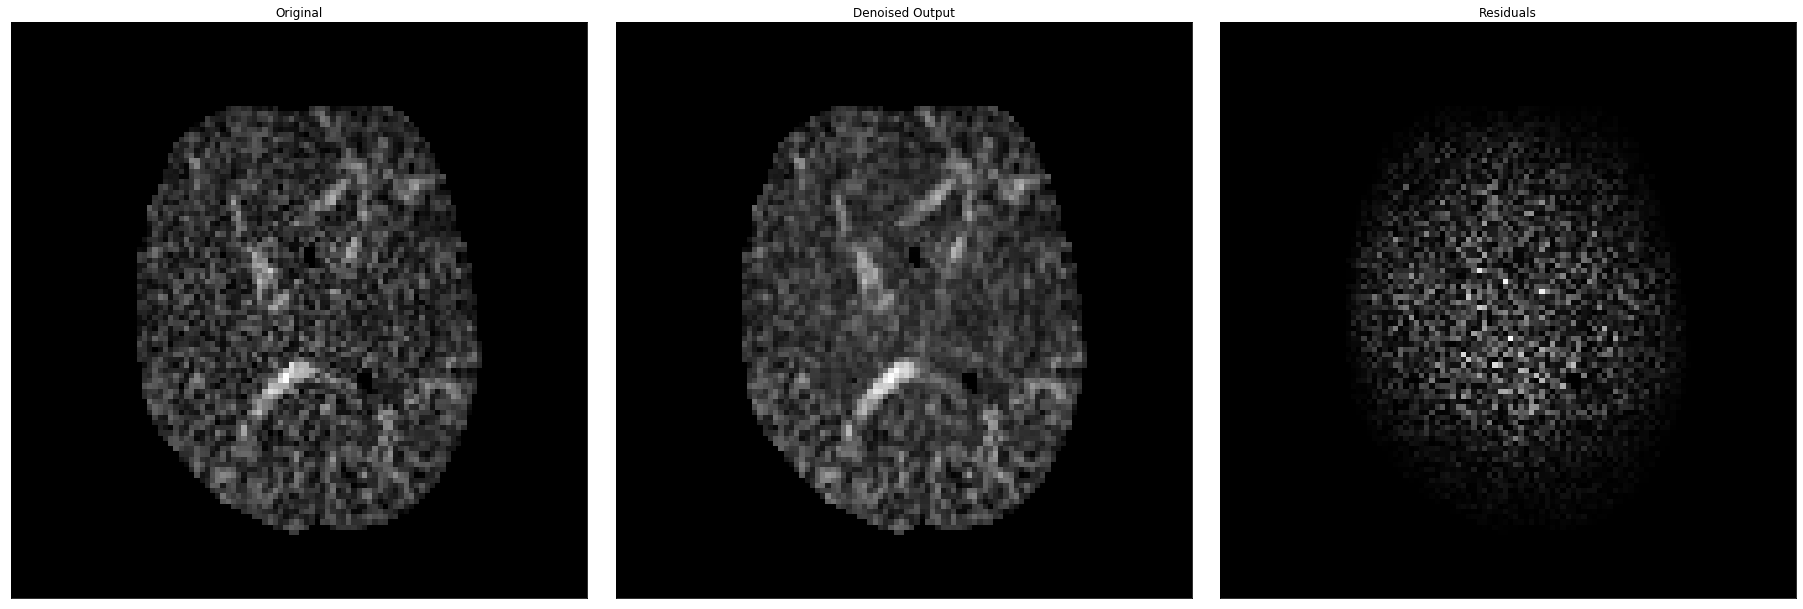

In [15]:
sli = maskdata.shape[2] // 2
gra = maskdata.shape[3] - 1
orig = maskdata[:, :, sli, gra]
den = denoised[:, :, sli, gra]
rms_diff = np.sqrt((orig - den) ** 2)
plt.figure(figsize=(16,8))
fig1, ax = plt.subplots(1, 3, figsize=(32, 16),subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(orig.T, cmap='gray', interpolation='none',origin='lower')
ax.flat[0].set_title('Original')
ax.flat[1].imshow(den.T, cmap='gray', interpolation='none',origin='lower')
ax.flat[1].set_title('Denoised Output')
ax.flat[2].imshow(rms_diff.T, cmap='gray', interpolation='none',origin='lower')
ax.flat[2].set_title('Residuals')
fig1.savefig('denoised_mppca.png');

In [25]:
import math 
print(math.ceil((np.shape(maskdata)[3]**(1/3)-1)/2))

2


# White matter segmentation

volumes : (156, 256, 256)
>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
>> Iteration: 10
>> Iteration: 11
>> Iteration: 12
>> Iteration: 13
>> Iteration: 14
>> Iteration: 15
>> Iteration: 16
>> Iteration: 17
>> Iteration: 18
>> Iteration: 19
>> Iteration: 20
>> Iteration: 21
>> Iteration: 22
>> Iteration: 23
>> Iteration: 24
>> Iteration: 25
>> Iteration: 26
>> Iteration: 27
>> Iteration: 28
>> Iteration: 29
>> Iteration: 30


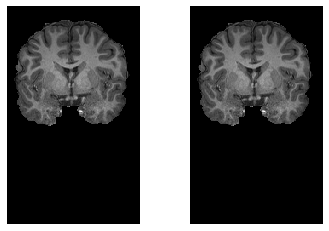

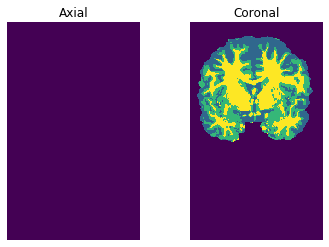

In [4]:
from dipy.segment.tissue import TissueClassifierHMRF


data, affine, img = load_nifti("anat/test_sag_T1_MPRAGE_1x1x1_20200214163511_2_brain_brain.nii.gz", return_img=True)
print('volumes :',data.shape)

nclass = 3
beta = 0.1
hmrf = TissueClassifierHMRF()
initial_segmentation, final_segmentation, PVE = hmrf.classify(data, nclass, beta)

(156, 256, 256)
(156, 256, 256)
(156, 256, 256, 3)


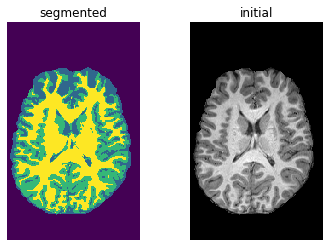

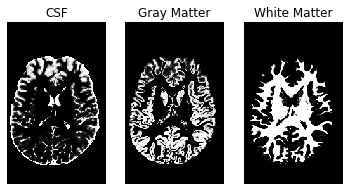

In [20]:
fig = plt.figure() 
a = fig.add_subplot(1, 2, 1) 
img_ax = np.rot90(final_segmentation[..., 180]) 
imgplot = plt.imshow(img_ax) 
a.axis('off') 
a.set_title('segmented') 
a = fig.add_subplot(1, 2, 2) 
img_cor = np.rot90(final_segmentation[:, 128, :]) 
imgplot = plt.imshow(data[..., 180].T, cmap='gray', origin='lower')
a.axis('off') 
a.set_title('initial') 
plt.savefig('final_seg.png', bbox_inches='tight', pad_inches=0)


fig = plt.figure()
a = fig.add_subplot(1, 3, 1)
img_ax = np.rot90(PVE[..., 180, 0])
imgplot = plt.imshow(img_ax, cmap="gray")
a.axis('off')
a.set_title('CSF')
a = fig.add_subplot(1, 3, 2)
img_cor = np.rot90(PVE[:, :, 180, 1])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Gray Matter')
a = fig.add_subplot(1, 3, 3)
img_cor = np.rot90(PVE[:, :, 180, 2])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('White Matter')
plt.savefig('probabilities.png', bbox_inches='tight', pad_inches=0)
plt.show()

# T1 registration

moving voxel size : (1.0, 1.0, 1.0)
moving shape :  (156, 256, 256)
static voxel size : (0.8594, 0.8594, 2.0)
static shape :  (256, 256, 68)


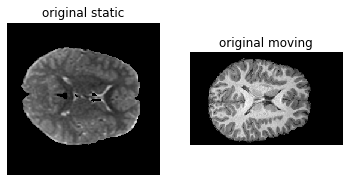

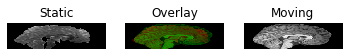

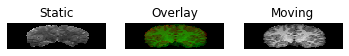

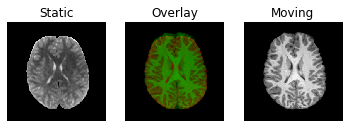

In [3]:
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
from dipy.viz import regtools


moving_data, moving_affine, img = load_nifti("anat/test_sag_T1_MPRAGE_1x1x1_20200214163511_2_brain_brain.nii.gz", return_img=True)
print('moving voxel size :',img.header.get_zooms()[:3])
moving = moving_data
print('moving shape : ',np.shape(moving))
moving_grid2world = moving_affine

static_data, static_affine, img = load_nifti("dys_diffusion/46DYS_DWI.nii.gz", return_img=True)
maskdata, mask = median_otsu(static_data, vol_idx=range(10,50), median_radius=2, numpass=1, autocrop=False)
static_data = maskdata
print('static voxel size :',img.header.get_zooms()[:3])
static = np.squeeze(static_data)[..., 0]
print('static shape : ',np.shape(static))
static_grid2world = static_affine

fig = plt.figure() 
a = fig.add_subplot(1, 2, 1) 
imgplot = plt.imshow(static[:,:, 30], cmap='gray', origin='lower') 
a.axis('off') 
a.set_title('original static') 
a = fig.add_subplot(1, 2, 2) 
imgplot = plt.imshow(moving[:,:, 180], cmap='gray', origin='lower')
a.axis('off') 
a.set_title('original moving') 
plt.show()

identity = np.eye(4)
affine_map = AffineMap(identity,static.shape, static_grid2world,moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)
regtools.overlay_slices(static, resampled, None, 0,"Static", "Moving", "resampled_0.png")
regtools.overlay_slices(static, resampled, None, 1,"Static", "Moving", "resampled_1.png")
regtools.overlay_slices(static, resampled, None, 2,"Static", "Moving", "resampled_2.png")
plt.show();


(256, 256, 68)
0


C:\Users\SIMON MATHIEU\AppData\Roaming\Python\Python37\site-packages\dipy\viz\regtools.py:383: RuntimeWarning: invalid value encountered in true_divide
  R = 255 * (R - R.min()) / (R.max() - R.min())


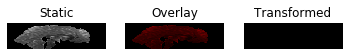

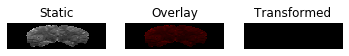

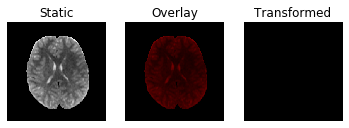

In [4]:
c_of_mass = transform_centers_of_mass(static, static_grid2world,moving, moving_grid2world)

transformed = c_of_mass.transform(moving)
print(np.shape(transformed))
print(np.sum(transformed != 0))
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_com_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_com_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_com_2.png")
plt.show()


Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


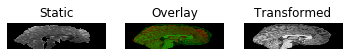

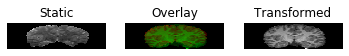

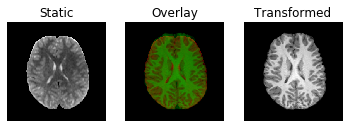

In [5]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)
transform = TranslationTransform3D()
params0 = None
starting_affine = affine_map.affine #c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,
                              static_grid2world, moving_grid2world,
                              starting_affine=starting_affine)
transformed = translation.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")
plt.show()


Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


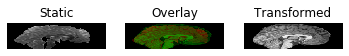

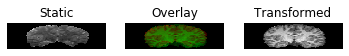

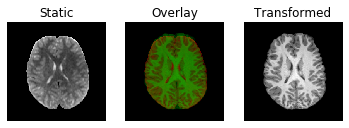

In [6]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)
transformed = rigid.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_rigid_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_rigid_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_rigid_2.png")
plt.show()




Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


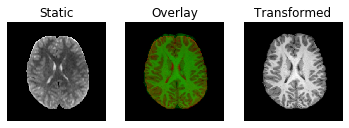

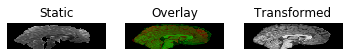

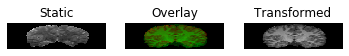

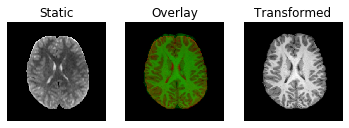

In [7]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)
transformed = affine.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_affine_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_affine_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_affine_2.png")


In [8]:
save_nifti('transformed.nii.gz', transformed.astype(np.float32),static_grid2world)

# White matter registred mask

In [ ]:

from dipy.align.imaffine import (AffineMap,MutualInformationMetric,AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,RigidTransform3D,AffineTransform3D)
# Read the moving image ====================================
moving_data, moving_affine, img = load_nifti("anat/test_sag_T1_MPRAGE_1x1x1_20200214163511_2_brain_brain.nii.gz", return_img=True)
moving = moving_data
moving_grid2world = moving_affine
# Read the static image ====================================
static_data, static_affine, img = load_nifti("dys_diffusion/46DYS_DWI.nii.gz", return_img=True)
maskdata, mask = median_otsu(static_data, vol_idx=range(10,50), median_radius=2, numpass=1, autocrop=False)
static_data = maskdata
static = np.squeeze(static_data)[..., 0]
static_grid2world = static_affine
# Reslice the moving image ====================================
identity = np.eye(4)
affine_map = AffineMap(identity,static.shape, static_grid2world,moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)
# translation the moving image ====================================
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affreg = AffineRegistration(metric=metric,level_iters=level_iters,sigmas=sigmas,factors=factors)
transform = TranslationTransform3D()
params0 = None
starting_affine = affine_map.affine #c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,static_grid2world, moving_grid2world, starting_affine=starting_affine)
transformed = translation.transform(moving)
# Rigid transform the moving image ====================================
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,static_grid2world, moving_grid2world,starting_affine=starting_affine)
transformed = rigid.transform(moving)
# affine transform the moving image ====================================
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,static_grid2world, moving_grid2world,starting_affine=starting_affine)
transformed = affine.transform(moving)

In [20]:
from dipy.segment.tissue import TissueClassifierHMRF
# final result of registration ==========================================
anat = transformed
anat_affine = static_grid2world
# make the white matter segmentation ===================================
nclass = 3
beta = 0.1
hmrf = TissueClassifierHMRF()
initial_segmentation, final_segmentation, PVE = hmrf.classify(anat, nclass, beta)

>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
>> Iteration: 10
>> Iteration: 11
>> Iteration: 12
>> Iteration: 13
>> Iteration: 14
>> Iteration: 15
>> Iteration: 16
>> Iteration: 17
>> Iteration: 18
>> Iteration: 19
>> Iteration: 20
>> Iteration: 21
>> Iteration: 22
>> Iteration: 23
>> Iteration: 24
>> Iteration: 25
>> Iteration: 26
>> Iteration: 27
>> Iteration: 28
>> Iteration: 29
>> Iteration: 30
>> Iteration: 31
>> Iteration: 32
>> Iteration: 33
>> Iteration: 34
>> Iteration: 35
>> Iteration: 36
>> Iteration: 37
>> Iteration: 38
>> Iteration: 39
>> Iteration: 40
>> Iteration: 41
>> Iteration: 42
>> Iteration: 43
>> Iteration: 44
>> Iteration: 45
>> Iteration: 46
>> Iteration: 47
>> Iteration: 48
>> Iteration: 49
>> Iteration: 50


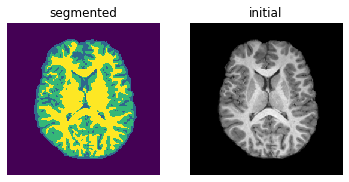

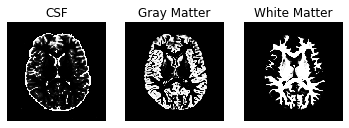

In [21]:
fig = plt.figure() 
a = fig.add_subplot(1, 2, 1) 
img_ax = np.rot90(final_segmentation[..., 30]) 
imgplot = plt.imshow(img_ax) 
a.axis('off') 
a.set_title('segmented') 
a = fig.add_subplot(1, 2, 2) 
img_cor = np.rot90(final_segmentation[:, 128, :]) 
imgplot = plt.imshow(anat[..., 30].T, cmap='gray', origin='lower')
a.axis('off') 
a.set_title('initial') 
plt.savefig('final_seg.png', bbox_inches='tight', pad_inches=0)


fig = plt.figure()
a = fig.add_subplot(1, 3, 1)
img_ax = np.rot90(PVE[..., 30, 0])
imgplot = plt.imshow(img_ax, cmap="gray")
a.axis('off')
a.set_title('CSF')
a = fig.add_subplot(1, 3, 2)
img_cor = np.rot90(PVE[:, :, 30, 1])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Gray Matter')
a = fig.add_subplot(1, 3, 3)
img_cor = np.rot90(PVE[:, :, 30, 2])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('White Matter')
plt.savefig('probabilities.png', bbox_inches='tight', pad_inches=0)
plt.show()

white_mask = PVE[..., 2]
white_mask[white_mask >= 0.05] = 1
white_mask[white_mask < 0.05] = 0
save_nifti('white_mask.nii.gz', white_mask.astype(np.float32),static_grid2world)


# Reslice


In [5]:
from dipy.align.reslice import reslice

data, affine, voxel_size = load_nifti("reslice/11TD_DWI.nii.gz", return_voxsize=True)
print(data.shape)
print(voxel_size)

new_voxel_size = (2., 2., 2.)
print(new_voxel_size)

data2, affine2 = reslice(data, affine, voxel_size, new_voxel_size)
print(data2.shape)

save_nifti('11TD_iso_vox.nii.gz', data2, affine2)

(256, 256, 68, 167)
(0.8594, 0.8594, 2.0)
(2.0, 2.0, 2.0)
(110, 110, 68, 167)


# Gibbs ringing

In [3]:
from dipy.denoise.gibbs import gibbs_removal

data, affine = load_nifti("gibbs_correct/convert_ep2d_diff_55dir_ISO_20180613113624_5.nii.gz")

data_corrected = gibbs_removal(data)
save_nifti('gibbs_corrected.nii.gz', data_corrected, affine)



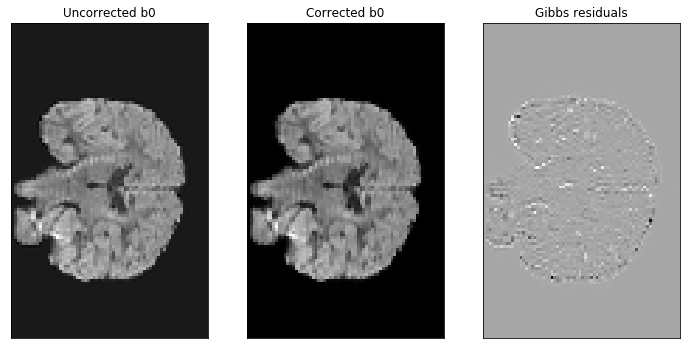

In [13]:
fig2, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(data[:, 50, :, 1], cmap='gray')
ax.flat[0].set_title('Uncorrected b0')
ax.flat[1].imshow(data_corrected[:, 50, :, 1], cmap='gray')
ax.flat[1].set_title('Corrected b0')
ax.flat[2].imshow(data_corrected[:, 50, :, 1] - data[:, 50, :, 1],cmap='gray')
ax.flat[2].set_title('Gibbs residuals')

plt.show()
fig2.savefig('Gibbs_suppression_b0.png')